<a href="https://colab.research.google.com/github/fedhere/MLTSA_FBianco/blob/master/HW2/ARIMA_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import glob
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import json
import os

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")

# data ingestion

In [0]:
# download kaggle economic data
#https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data#a.us.txt


In [5]:
!pip install kaggle


In [6]:
from google.colab import drive

drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
cd /content

/content


In [8]:
cd gdrive/My\ Drive/


/content/gdrive/My Drive


In [9]:
ls kaggle.json


kaggle.json


In [0]:
!chmod 600 kaggle.json

In [0]:

envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']


In [12]:
os.environ

environ({'ENV': '/root/.bashrc', 'GCS_READ_CACHE_BLOCK_SIZE_MB': '16', 'CLOUDSDK_CONFIG': '/content/.config', 'CUDA_VERSION': '10.1.243', 'PATH': '/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin', 'HOME': '/root', 'LD_LIBRARY_PATH': '/usr/local/nvidia/lib:/usr/local/nvidia/lib64', 'LANG': 'en_US.UTF-8', 'SHELL': '/bin/bash', 'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs', 'CUDA_PKG_VERSION': '10-1=10.1.243-1', 'SHLVL': '1', 'GCE_METADATA_TIMEOUT': '0', 'NCCL_VERSION': '2.4.8', 'NVIDIA_VISIBLE_DEVICES': 'all', 'TF_FORCE_GPU_ALLOW_GROWTH': 'true', 'DEBIAN_FRONTEND': 'noninteractive', 'CUDNN_VERSION': '7.6.5.32', 'LAST_FORCED_REBUILD': '20200204', 'JPY_PARENT_PID': '18', 'PYTHONPATH': '/env/python', 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\\"172.28.0.2\\""]}', 'NO_GCE_CHECK': 'True', 'GLIBCXX_FORCE_NEW':

In [13]:
!mkdir MLTSA

mkdir: cannot create directory ‘MLTSA’: File exists


In [14]:
cd MLTSA

/content/gdrive/My Drive/MLTSA


In [15]:
!mkdir HW2 

mkdir: cannot create directory ‘HW2’: File exists


In [16]:
cd HW2

/content/gdrive/My Drive/MLTSA/HW2


In [17]:
!kaggle datasets download borismarjanovic/price-volume-data-for-all-us-stocks-etfs



price-volume-data-for-all-us-stocks-etfs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
!ls

Data
price-volume-data-for-all-us-stocks-etfs.zip
tesla-stock-data-from-2010-to-2020.zip


In [19]:
!unzip price-volume-data-for-all-us-stocks-etfs.zip

Archive:  price-volume-data-for-all-us-stocks-etfs.zip
replace Data/ETFs/aadr.us.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [39]:

alltss = []

allfiles = np.sort(np.array(glob.glob("Data/Stocks/*.txt")))[:10]
tss = pd.read_csv(allfiles[0])[["Date", "Close"]].rename({"Close":
              allfiles[0].replace(".txt",
                                  "").replace("Data/Stocks/", 
                                              "")}, axis=1)
for f in allfiles[1:]:
    print(f)
    name = f.replace(".txt","").replace("Data/Stocks/", "")
    
    tss = tss.merge(pd.read_csv(f)[["Date", "Close"]].rename({"Close":
                                                              name}, 
                                        axis=1), on="Date")
tss.set_index("Date", inplace=True)
    

Data/Stocks/aa.us.txt
Data/Stocks/aaap.us.txt
Data/Stocks/aaba.us.txt
Data/Stocks/aac.us.txt
Data/Stocks/aal.us.txt
Data/Stocks/aamc.us.txt
Data/Stocks/aame.us.txt
Data/Stocks/aan.us.txt
Data/Stocks/aaoi.us.txt


#  data inspection

plot each time series (ts)

In [40]:
tss.iloc[0], tss.iloc[-1] 

(a.us       36.901
 aa.us      17.779
 aaap.us    24.500
 aaba.us    33.380
 aac.us     22.560
 aal.us     43.524
 aamc.us    20.750
 aame.us     4.796
 aan.us     24.649
 aaoi.us    16.760
 Name: 2015-11-11, dtype: float64, a.us       66.81
 aa.us      43.01
 aaap.us    80.98
 aaba.us    70.56
 aac.us     11.28
 aal.us     45.82
 aamc.us    80.10
 aame.us     3.50
 aan.us     36.59
 aaoi.us    45.30
 Name: 2017-11-10, dtype: float64)

(447, 10)

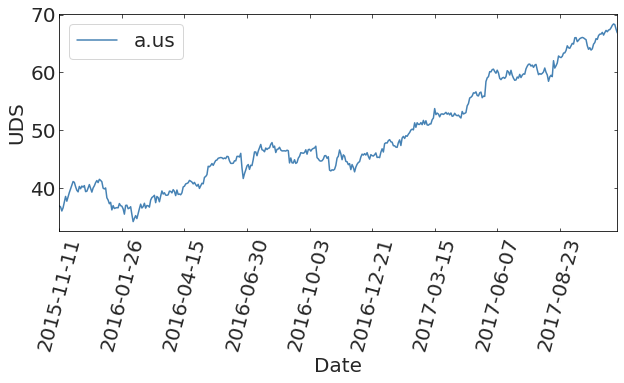

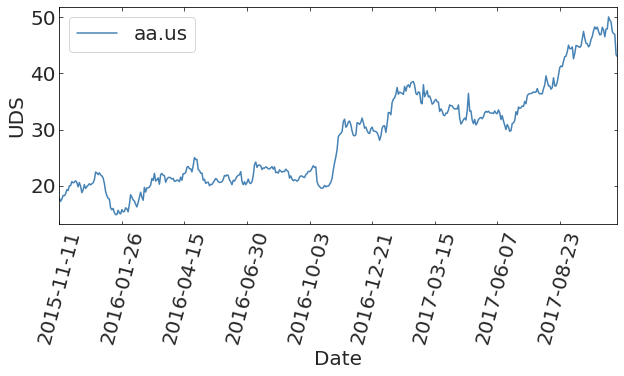

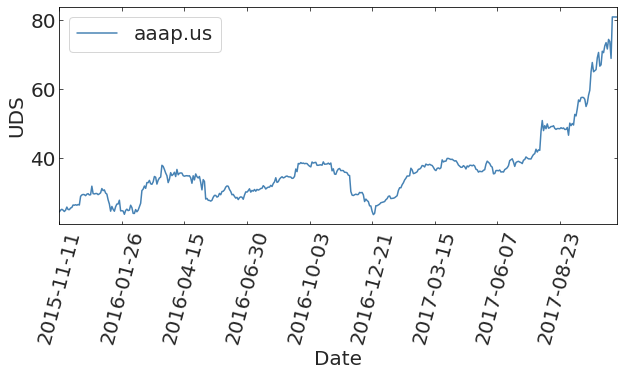

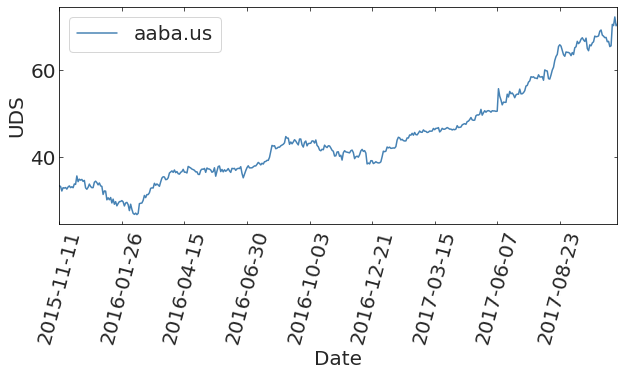

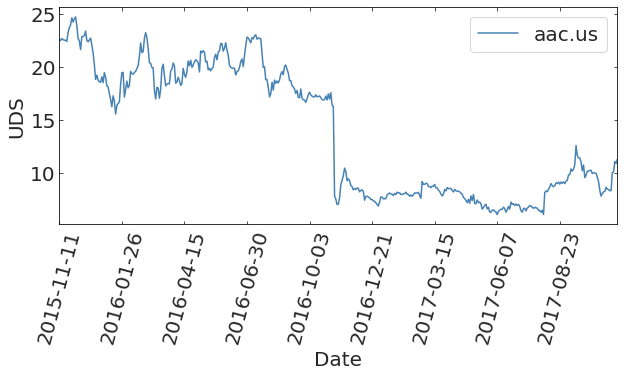

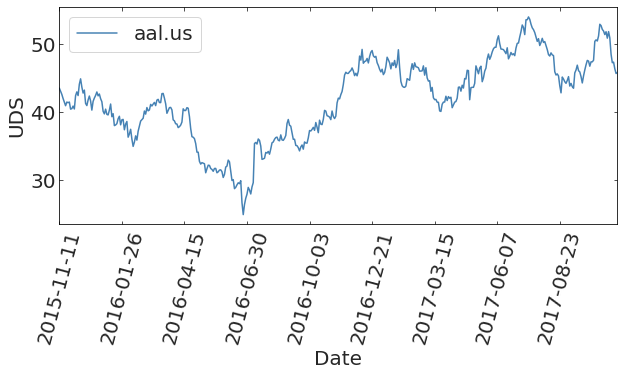

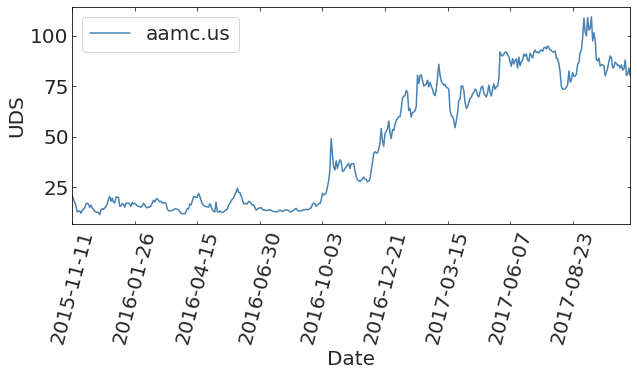

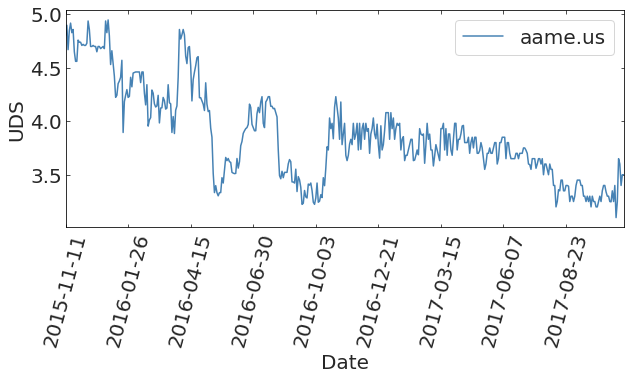

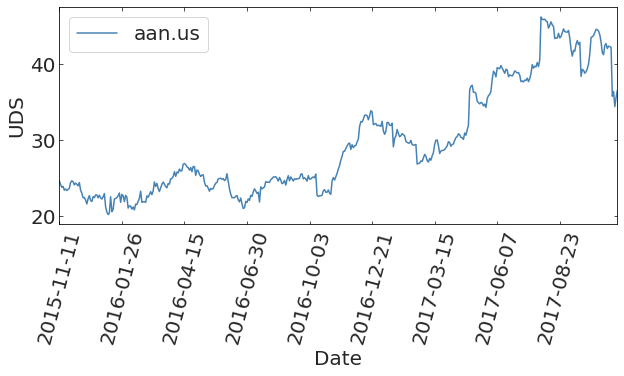

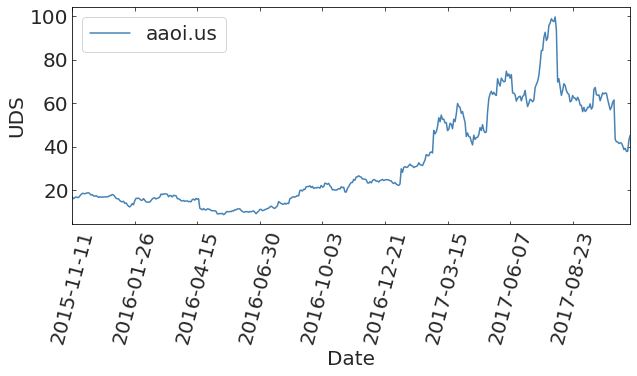

In [41]:
for c in tss.columns:
    fig, ax = pl.subplots(figsize=(10,4))
    tss.plot(y=c, ax=ax, rot=75)
    ax.set_ylabel("UDS")

tss.shape

Fig 1: Stock daily close value for 10 stocks between 11/11/2015 and 11/10/2017 in USD for 10 stocks, the first 10 in alphabetical order in the data avaialble at https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data#a.us.txt


## visualizing correlations

use ```pandas.plotting.scatter_matrix```  to look at the relationship between lightcurves

plot the pairwise correlation as a heatmap using ```pl.imshow()```. You can access the pairwise correlation with the dataframe method ```df.corr()```

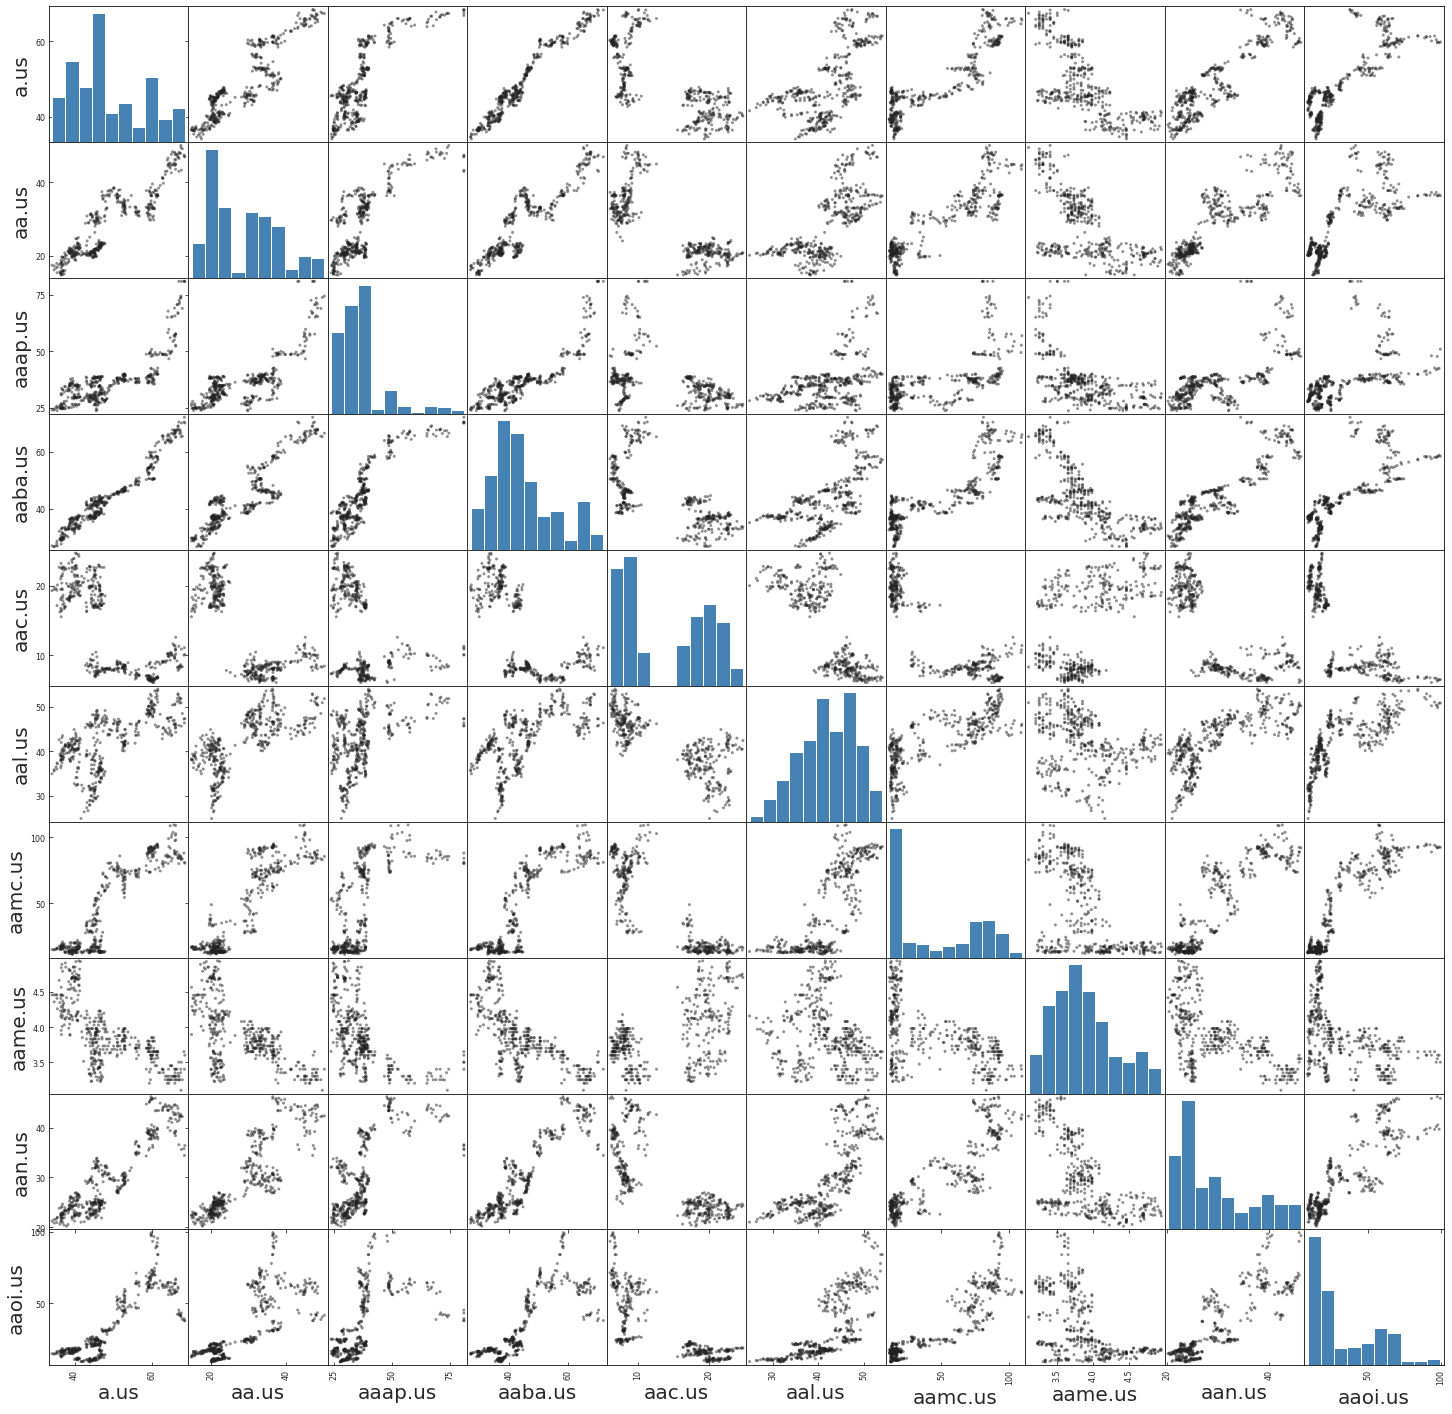

In [42]:
scatter_matrix(tss, figsize=(25,25), color="#222222");

Fig 2: Scatter matrix showing the distribution and correlations of closing stock price time series from the dtaset shown in Fig 1. The diagonal cells show a histogram of the price in the two-year time period considered, between November 2015 and 2017. The off diagonal cells show the pair-wise correlation of the stock=price time series. Several time series display behaviors significantly different from a bell-curve, and therefore inconsistent with a stationary stockastic behavior. While most pairs dhow a generally positive correlation, with different degree of strength, aame.us shows an inverse, albeit noisy, correlation with most time series. A correlation matrix would help confirm this visual result.

In [43]:
print("Correlation matrix of 2015-2017 stock values")
tss.corr()

Correlation matrix of 2015-2017 stock values


a.us     aa.us   aaap.us  ...   aame.us    aan.us   aaoi.us
a.us     1.000000  0.902139  0.800310  ... -0.699609  0.905395  0.851239
aa.us    0.902139  1.000000  0.776600  ... -0.606774  0.873520  0.766459
aaap.us  0.800310  0.776600  1.000000  ... -0.573976  0.696179  0.560427
aaba.us  0.973457  0.904210  0.872134  ... -0.709023  0.903785  0.809059
aac.us  -0.721867 -0.791137 -0.423021  ...  0.510986 -0.765267 -0.780147
aal.us   0.621041  0.713229  0.451520  ... -0.219258  0.756808  0.746505
aamc.us  0.897263  0.893952  0.621329  ... -0.544740  0.881631  0.904166
aame.us -0.699609 -0.606774 -0.573976  ...  1.000000 -0.585002 -0.496371
aan.us   0.905395  0.873520  0.696179  ... -0.585002  1.000000  0.860847
aaoi.us  0.851239  0.766459  0.560427  ... -0.496371  0.860847  1.000000

[10 rows x 10 columns]

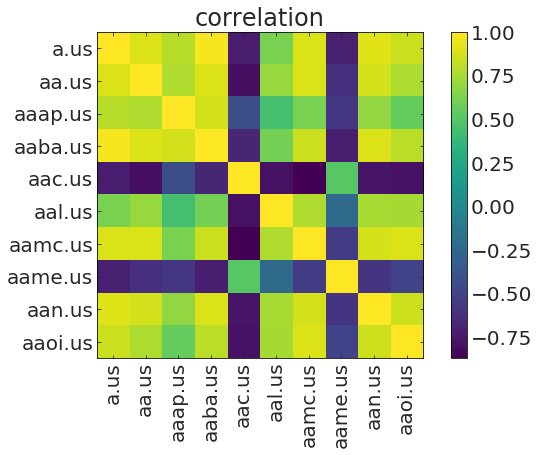

In [44]:
pl.imshow(tss.corr())
pl.colorbar()
pl.title("correlation")
pl.xticks(range(len(tss.columns)), tss.columns, rotation=90)
pl.yticks(range(len(tss.columns)), tss.columns);


Fig 3: Pairwise Pearson correolation coefficient of the time series shown in Figure 1. Most time series show a positive correlation, but aame.us and aaba.us show a negative correlation with all other time series. The most strongly correlated series are a.us and aabe.us (r = 0.97), and most strongly inversely correlated time xeries are aac.us and aamc.us (r = -0.87). 

## testing for stationarity
test if each of these time series is stationary using the AD fuller test using ```statsmodels.api.tsa.stattools.adfuller()```

```for f in tss.columns:
    sm.tsa.stattools.adfuller(tss[c])```

Have the code automatically print a statement about wheather the ts is stationary for each ts (for example in a for loop).

In [45]:
threshold = 0.05
print ("Stationarity results from the AD Fuller test at a p-value of 0.05")
for c in tss.columns:
    print(c, "is stationary:", sm.tsa.stattools.adfuller(tss[c])[1] < threshold)

Stationarity results from the AD Fuller test at a p-value of 0.05
a.us is stationary: False
aa.us is stationary: False
aaap.us is stationary: False
aaba.us is stationary: False
aac.us is stationary: False
aal.us is stationary: False
aamc.us is stationary: False
aame.us is stationary: True
aan.us is stationary: False
aaoi.us is stationary: False


## measure autocorrelation

plot the time series and its autocorrelation and partial autocorrelation function in blue if it is not stationary, in red if it is stationary

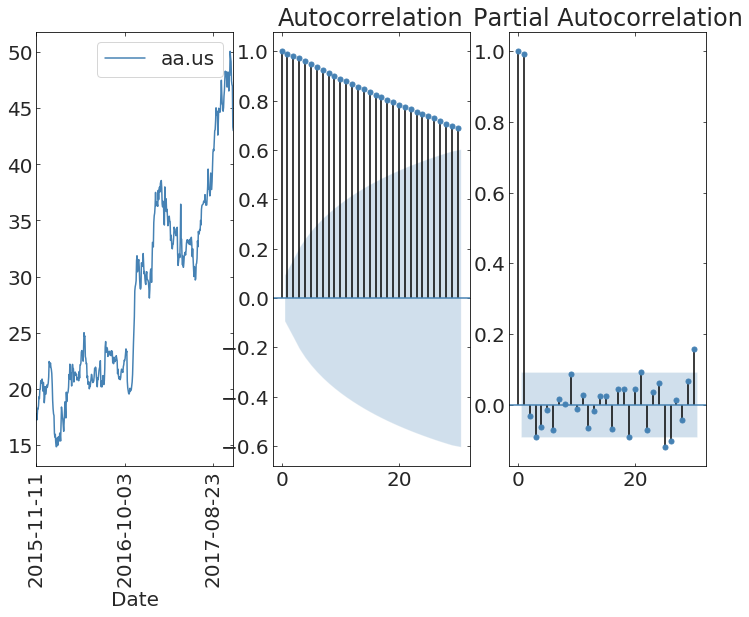

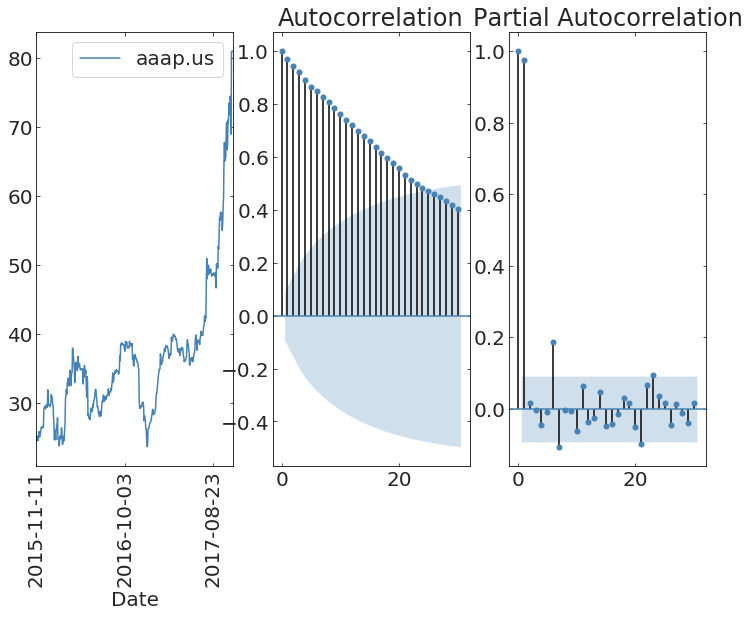

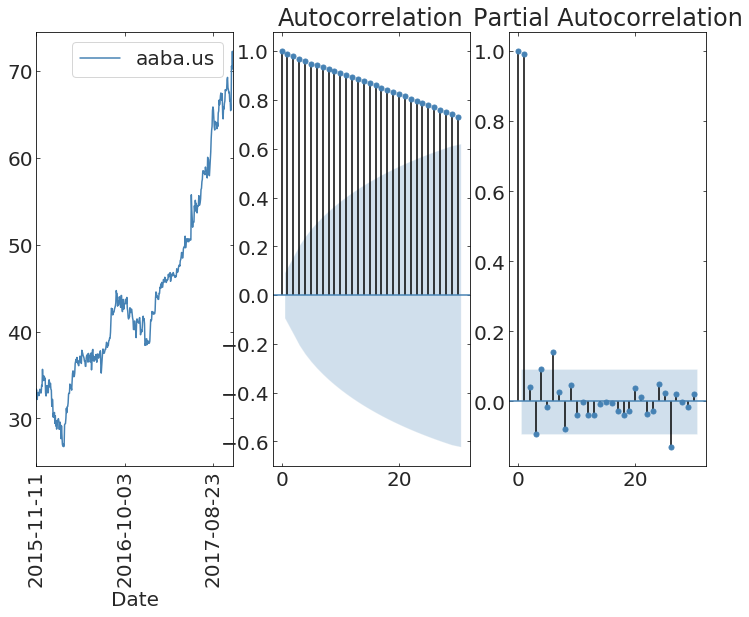

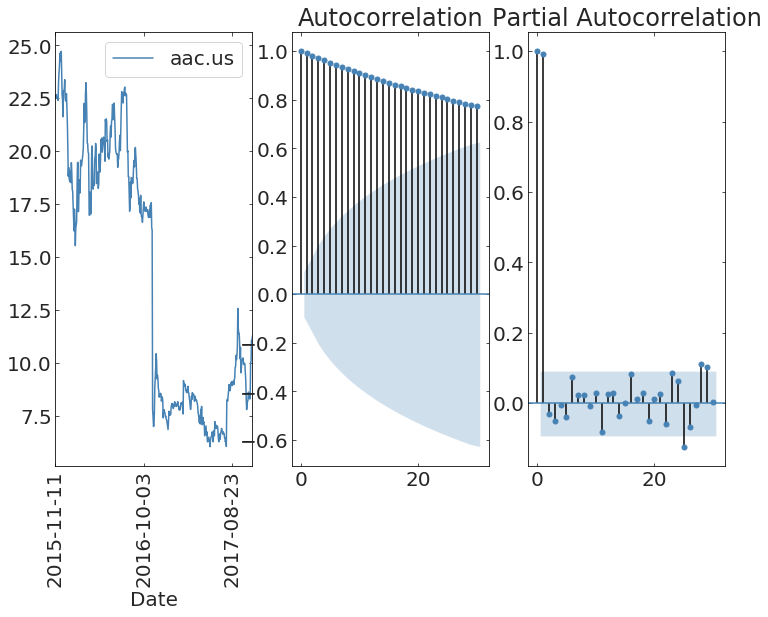

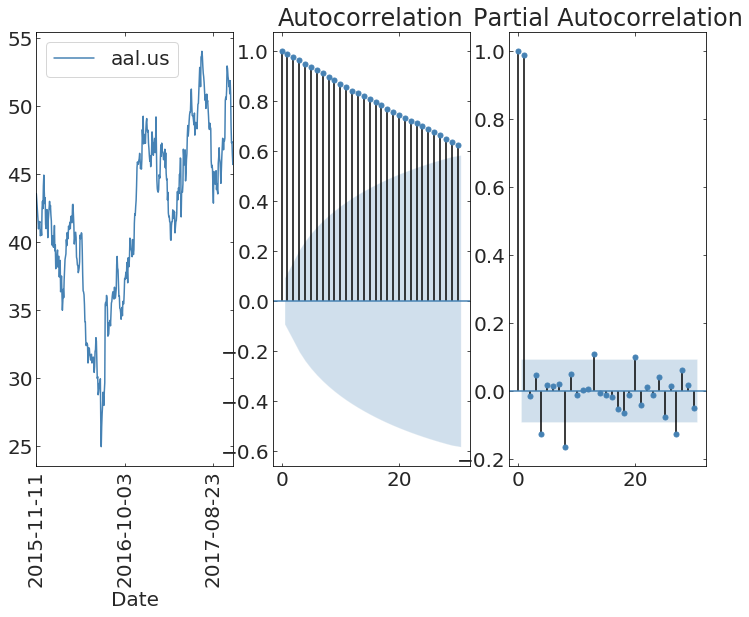

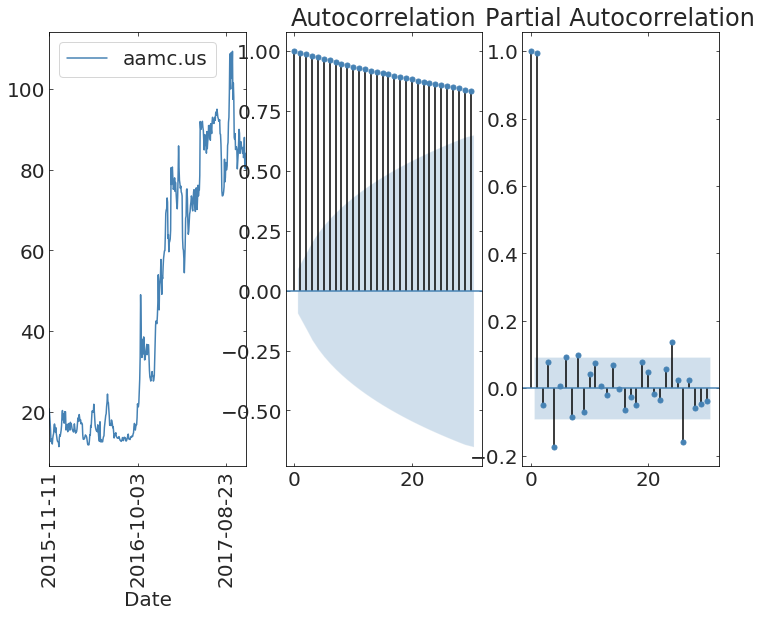

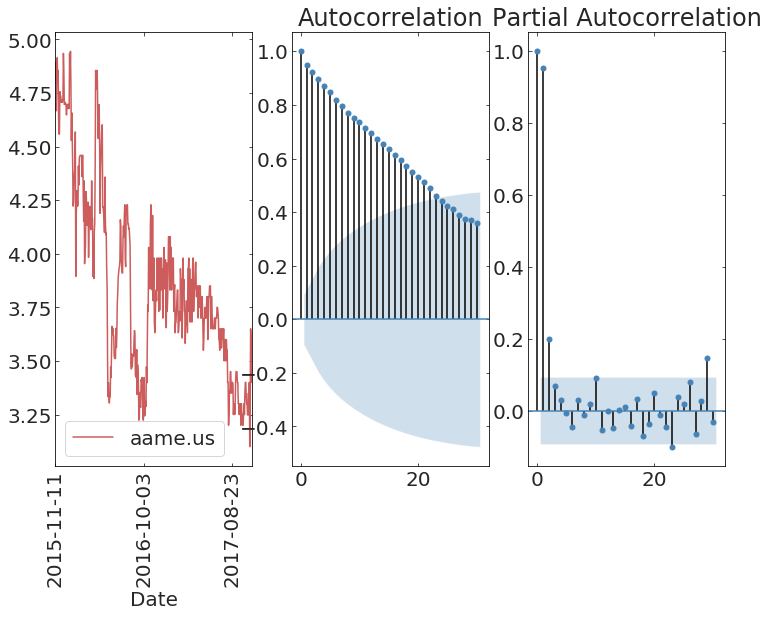

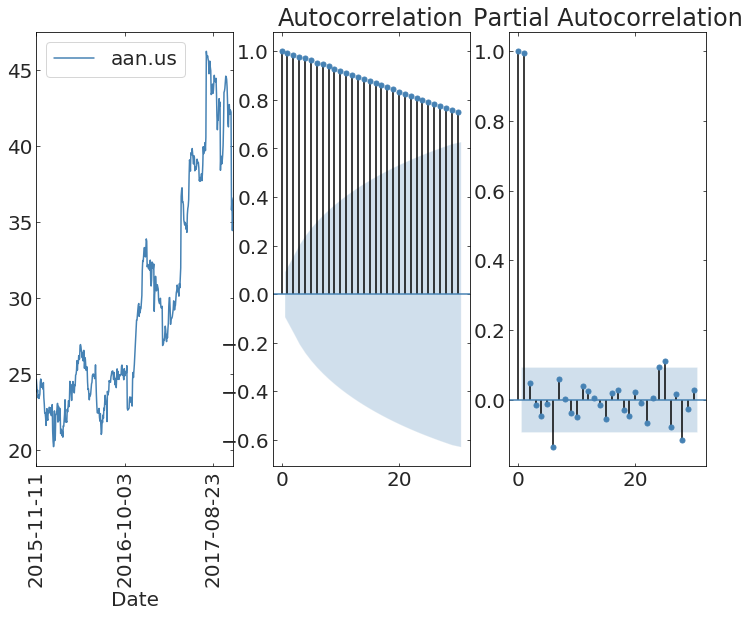

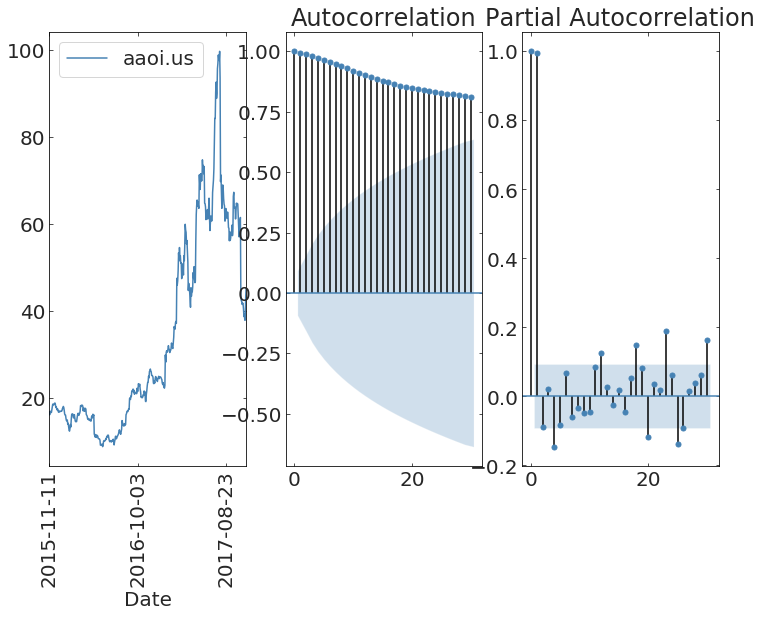

In [46]:
for c in tss.columns[1:]:
    color = "SteelBlue"
    if sm.tsa.stattools.adfuller(tss[c])[1] < threshold:
        color = "IndianRed"
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(131)
    tss[[c]].plot(figsize=(12,8),  rot=90, color=color, ax=ax1);
    ax2 = fig.add_subplot(132)
    fig = sm.graphics.tsa.plot_acf(tss[c], lags=30, ax=ax2)
    ax3 = fig.add_subplot(133)
    fig = sm.graphics.tsa.plot_pacf(tss[c], lags=30, ax=ax3);

Fig 4: This set of figures show series of 3 plots: the time series, autocorrelation, and partial autocorrelation for each time series. The Autocorrelation and partial autocorrelation are shown for up to 30 lags. pale blue shaded regions are confidence intervals: of particular interest is the partial autocorrelation plot, where only lags outside of the confidence interval are significant (anc shall be used in ARMA models). Time series shown in red are stationary, according to an AD Fuller test at a 0.05 p-value.

# Fit one of the stationary time series with ARMA

To fit the model to the data use ```statsmodels.api.tsa.ARMA```

Inspect the function call as ```statsmodels.api.tsa.ARMA?```

The statsmodels models are generally fit into 2 phases: generating the model ```sm.tsa.ARMA(data, parameters)```, and then fitting it ```sm.tsa.ARMA(data, parameters).fit()```. 

For at least one model look at the model summary ```mod.summary()``` What are the best fit parameters based on this printed summary and thewir uncertainties? What is the value of the AIC(Aikiki Information Criterion)

See https://github.com/fedhere/A-Data-Driven-Evaluation-of-Delays-in-Criminal-Prosecution/blob/master/CodeExamples/ARMA/testingARMA_ARIMA.ipynb

## 1 Fit the model for a variety of parameters. You can run a nested loop to iterate over a range of p and q parameters
## 2. record the aic score for each fit
## 3. Find the best parameters to fit this time series with the AIC minimization criterion. For each model, after you fit it to the data, you can get the value of the AIC as ```model.aic```

In [47]:
aics_st = np.zeros((5,5))
for p in range(5):
    for q in range(5):
        try:
            aics_st[p,q] = sm.tsa.ARMA(tss[['aame.us']], (p,q)).fit().aic
        except:
            aics_st[p,q] = np.nan
print("best parameters: ", np.where(aics_st == np.nanmin(aics_st)))

best parameters:  (array([1]), array([1]))


The best model parameters are p=1 and q=1: the autoregression process only has one step memore (t-1) and the moving average includes only the "error term" in the previous step.

---



In [48]:
mod = sm.tsa.ARMA(tss[['aame.us']], (1,1)).fit()

#(tss[c], (3,1), dates=tss["Date"], ).fit()
#mod.plot_predict(dynamic=True, plot_insample=False)
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                aame.us   No. Observations:                  447
Model:                     ARMA(1, 1)   Log Likelihood                 301.057
Method:                       css-mle   S.D. of innovations              0.123
Date:                Sat, 29 Feb 2020   AIC                           -594.115
Time:                        02:22:08   BIC                           -577.705
Sample:                             0   HQIC                          -587.645
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.9275      0.204     19.247      0.000       3.528       4.327
ar.L1.aame.us     0.9811      0.010    100.057      0.000       0.962       1.000
ma.L1.aame.us    -0.2706      0.049     -5.576      0.000      -0.366      -0.175
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0192           +0.0000j            1.0192            0.0000
MA.1            3.6958           +0.0000j            3.6958            0.0000
-----------------------------------------------------------------------------
"""

## 4. predict the in-set and the future alues

you can use ```mod.plot_predict()``` to visualize them

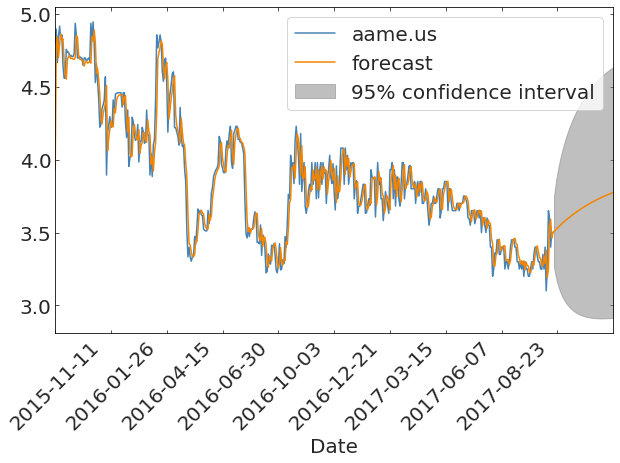

In [54]:
ax = tss[['aame.us']].plot()

mod.plot_predict(end=500, plot_insample=False, ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

# 3.5 what are the coefficients of the best fit model? what do they mean? 


The best model parameters are p=1 and q=1: the autoregression process only has one step memore (t-1) and the moving average includes only the "error term" in the previous step.

The coefficient include a constant term that represents the baseline of the time series set to :const	3.9275	+/-0.204.

The single AR coefficient is positive (positive autocorrelation) set to ~1, and the only moving average coefficeint is negative and close to 0


#  choose 2 non stationary time series in the set that are not correlated and repeat steps 3.1-3.4 with the ARIMA model

choose a value of the integration order that is reasonable ...

In [55]:
lcs = ["aal.us", "a.us"]
print("choosint 2 time series {} {} and setting integration coefficient to 2".format(*lcs) )


choosint 2 time series aal.us a.us and setting integration coefficient to 2


In [56]:
aics = np.zeros((2, 5, 5))
for k,c in enumerate(lcs):
    for i in range(5):
        for j in range(5):
            print("parameters:", i, j)
        
            try:
                mod = sm.tsa.ARIMA(tss[c], (i,2,j)).fit()        
                aics[k][i][j] = mod.aic
            except:
                aics[k][i][j] = np.nan
        
            print("AIC", aics[k][i][j])

parameters: 0 0
AIC 1498.5991595572846
parameters: 0 1
AIC 1202.9189767535424
parameters: 0 2
AIC nan
parameters: 0 3
AIC nan
parameters: 0 4
AIC nan
parameters: 1 0
AIC 1390.1879243897804
parameters: 1 1
AIC 1204.8505256073242
parameters: 1 2
AIC 1202.3376840553067
parameters: 1 3
AIC 1203.185436845487
parameters: 1 4
AIC 1204.5548907069888
parameters: 2 0
AIC 1308.425357894856
parameters: 2 1
AIC 1205.7778388750403
parameters: 2 2
AIC 1203.0951167559986
parameters: 2 3
AIC 1198.93174966818
parameters: 2 4
AIC 1203.028092307042
parameters: 3 0
AIC 1289.8724155520076
parameters: 3 1
AIC 1203.7586096584703
parameters: 3 2
AIC 1204.8235538705248
parameters: 3 3
AIC 1203.0063894184673
parameters: 3 4
AIC 1202.3372019537205
parameters: 4 0
AIC 1279.2900045277822
parameters: 4 1
AIC 1205.6363829931283
parameters: 4 2
AIC 1206.0974050316763
parameters: 4 3
AIC nan
parameters: 4 4
AIC 1204.3341922259965
parameters: 0 0
AIC 1190.8691923301365
parameters: 0 1
AIC 850.9311762711179
parameters: 0

In [57]:
print ("best aal.us model: p=", np.arange(5)[np.where(aics[0] == np.nanmin(aics[0]))[0][0]])
print ("best aal.us model: p=", np.arange(5)[np.where(aics[0] == np.nanmin(aics[0]))[1][0]])
print ("best a.us model: p=", np.arange(5)[np.where(aics[1] == np.nanmin(aics[1]))[0][0]])
print ("best a.us model: p=", np.arange(5)[np.where(aics[1] == np.nanmin(aics[1]))[1][0]])

best aal.us model: p= 2
best aal.us model: p= 3
best a.us model: p= 4
best a.us model: p= 3


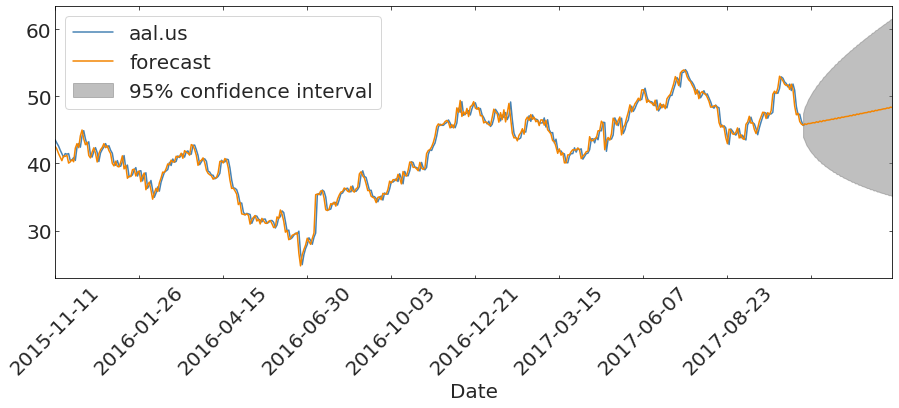

In [65]:
ax = tss[lcs[0]].plot(figsize=(15,5))
mod = sm.tsa.ARIMA(tss[lcs[0]], (np.where(aics[0] == np.nanmin(aics[0]))[0][0], 2,  
                                 np.where(aics[0] == np.nanmin(aics[0]))[1][0])).fit()    
mod.plot_predict(end=500, plot_insample=False, ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Fig 5: best ARIMA model for aal.us time series, including forecast of 53 future epochs anf its uncertainty. Model parameters are (p,i,q) = (2,2,3). The model is quite complex, with 7 free paramters, plus one for the constant baselin. However, the complicated shape of the lightcurve seems to justify the complexity. The black line is the data, the orance line the forecast, it's uncertainty is the gray shaded region. As expexcted, the uncertainty rapidly increases after the initial predictions. The trend is predicted to rise, despite the recent drop.

---



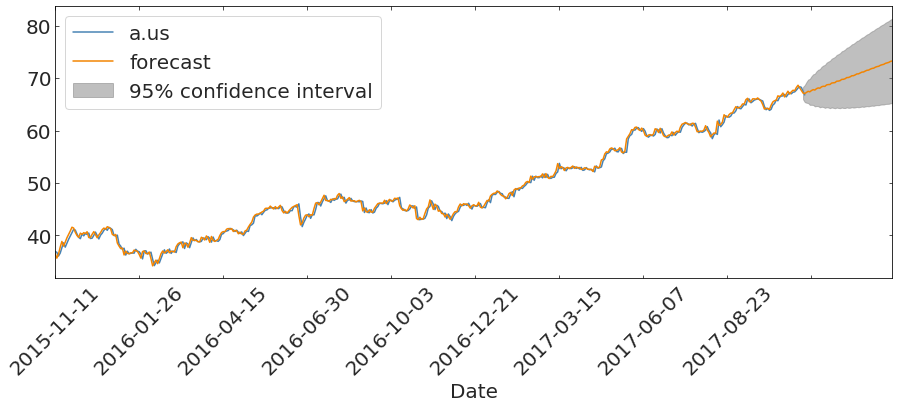

In [66]:
ax = tss[lcs[1]].plot(figsize=(15,5))
mod = sm.tsa.ARIMA(tss[lcs[1]], (np.where(aics[1] == np.nanmin(aics[1]))[0][0], 2,  
                                 np.where(aics[1] == np.nanmin(aics[1]))[1][0])).fit()    
mod.plot_predict(end=500, plot_insample=False, ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Fig 6: Same as figure 5 for the a.us data. Best ARIMA  parameters are (p,i,q) = (4,2,3). The black line is the data, the orance line the forecast, it's uncertainty is the gray shaded region. As expexcted, the uncertainty rapidly increases after the initial predictions. This time series has a more stationary behavior, and the uncertainty band is correspondingly smaller than for the prediction of aal.us.

# Redo the fit to one of the non-stsationary lightcurves with a different order of integration and compare the results. What do the coefficients tell you?

In [0]:
mod = sm.tsa.ARIMA(tss[["a.us"]], (4,2,3)).fit()    

In [61]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D2.a.us   No. Observations:                  445
Model:                 ARIMA(4, 2, 3)   Log Likelihood                -413.763
Method:                       css-mle   S.D. of innovations              0.606
Date:                Sat, 29 Feb 2020   AIC                            845.526
Time:                        02:23:56   BIC                            882.409
Sample:                             2   HQIC                           860.070
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.000      0.910      0.363      -0.000       0.001
ar.L1.D2.a.us    -1.1435      0.048    -23.937      0.000      -1.237      -1.050
ar.L2.D2.a.us    -1.0612      0.072    -14.684      0.000      -1.203      -0.920
ar.L3.D2.a.us    -0.1090      0.073     -1.502      0.134      -0.251       0.033
ar.L4.D2.a.us    -0.0414      0.048     -0.863      0.389      -0.135       0.053
ma.L1.D2.a.us     0.0713      0.010      6.962      0.000       0.051       0.091
ma.L2.D2.a.us    -0.0707      0.010     -7.026      0.000      -0.090      -0.051
ma.L3.D2.a.us    -0.9997      0.013    -77.809      0.000      -1.025      -0.975
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5692           -0.8556j            1.0276           -0.3434
AR.2           -0.5692           +0.8556j            1.0276            0.3434
AR.3           -0.7488           -4.7261j            4.7850           -0.2750
AR.4           -0.7488           +4.7261j            4.7850            0.2750
MA.1           -0.5355           -0.8445j            1.0000           -0.3399
MA.2           -0.5355           +0.8445j            1.0000            0.3399
MA.3            1.0003           -0.0000j            1.0003           -0.0000
-----------------------------------------------------------------------------
"""

In [0]:
modnew = sm.tsa.ARIMA(tss[["a.us"]], (4,1,3)).fit()    

In [63]:
modnew.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.a.us   No. Observations:                  446
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -412.716
Method:                       css-mle   S.D. of innovations              0.608
Date:                Sat, 29 Feb 2020   AIC                            843.431
Time:                        02:23:57   BIC                            880.334
Sample:                             1   HQIC                           857.981
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0669      0.027      2.463      0.014       0.014       0.120
ar.L1.D.a.us    -0.1575      0.052     -3.052      0.002      -0.259      -0.056
ar.L2.D.a.us    -0.0838      0.040     -2.110      0.035      -0.162      -0.006
ar.L3.D.a.us    -0.9227      0.037    -24.767      0.000      -0.996      -0.850
ar.L4.D.a.us    -0.1020      0.048     -2.107      0.036      -0.197      -0.007
ma.L1.D.a.us     0.0652      0.027      2.403      0.017       0.012       0.118
ma.L2.D.a.us     0.0856      0.037      2.334      0.020       0.014       0.157
ma.L3.D.a.us     0.9853      0.049     20.294      0.000       0.890       1.081
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4786           -0.9054j            1.0241           -0.1726
AR.2            0.4786           +0.9054j            1.0241            0.1726
AR.3           -1.0432           -0.0000j            1.0432           -0.5000
AR.4           -8.9616           -0.0000j            8.9616           -0.5000
MA.1            0.4626           -0.8881j            1.0013           -0.1736
MA.2            0.4626           +0.8881j            1.0013            0.1736
MA.3           -1.0121           -0.0000j            1.0121           -0.5000
-----------------------------------------------------------------------------
"""

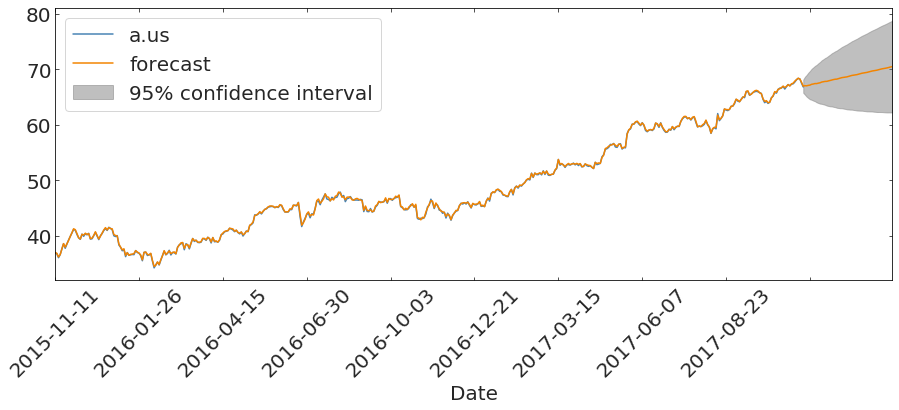

In [67]:
ax = tss[lcs[1]].plot(figsize=(15,5))
mod = sm.tsa.ARIMA(tss[lcs[1]], (4,1,3)).fit()    
mod.plot_predict(end=500, plot_insample=False, ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Fig 7: As in Fig 5 and 6, fit to a.us with same p and q as in Fig 6 but integration order 1 instead of 2. While the visual inspection fo the prediction does not reveal any obvious differences compared to the prediction in Fig 6, the model complexity is slightly reduced and the AIC value is slightly smaller, indicating that this simpler model is to be preferred. 